# PilotNet SDNN Example

Network excange module is available as `lava.lib.dl.netx.{hdf5, blocks, utils}`.
* `hdf5` implements automatic network generation.
* `blocks` implements individual layer blocks.
* `utils` implements hdf5 reading utilities. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io

from lava.lib.dl import netx
from dataset import PilotNetDataset

## Create network block

A network block can be created by simply instantiating `netx.hdf5.Network` with the path of the desired hdf5 network description file.
* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as as a list: `net.layers`.

In [2]:
net = netx.hdf5.Network(net_config='network.net')
print(net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Input     |  100|   33|    3|     |     |     |     |     |False|
|Conv      |   49|   16|   24| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   24|    7|   36| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   22|    4|   64| 3, 3| 1, 2| 0, 1| 1, 1|    1|False|
|Conv      |   20|    2|   64| 3, 3| 1, 1| 0, 0| 1, 1|    1|False|
|Dense     |    1|    1|  100|     |     |     |     |     |False|
|Dense     |    1|    1|   50|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|
|Dense     |    1|    1|    1|     |     |     |     |     |False|


In [3]:
print(f'There are {len(net)} layers in network:')

for l in net.layers:
    print(f'{l.__class__.__name__:5s} : {l.name:10s}, shape : {l.shape}')

There are 9 layers in network:
Input : Process_1 , shape : (100, 33, 3)
Conv  : Process_3 , shape : (49, 16, 24)
Conv  : Process_6 , shape : (24, 7, 36)
Conv  : Process_9 , shape : (22, 4, 64)
Conv  : Process_12, shape : (20, 2, 64)
Dense : Process_15, shape : (100,)
Dense : Process_18, shape : (50,)
Dense : Process_21, shape : (10,)
Dense : Process_24, shape : (1,)


In [4]:
num_samples = 200
steps_per_sample = 1
num_steps = num_samples + len(net.layers)

## Create Dataset instance
Typically the user would write it or provide it.

In [5]:
full_set = PilotNetDataset(
    path='../data',
    size=[100, 33],
    transform=net.in_layer.transform, # input transform
    visualize=True, # visualize ensures the images are returned in sequence
    sample_offset=10550,
)
train_set = PilotNetDataset(
    path='../data',
    size=[100, 33],
    transform=net.in_layer.transform, # input transform
    train=True,
)
test_set = PilotNetDataset(
    path='../data',
    size=[100, 33],
    transform=net.in_layer.transform, # input transform
    train=False,
)

# Instantiate Dataloader

In [6]:
dataloader = io.dataloader.SpikeDataloader(dataset=full_set)

# Connect Input and Output

In [7]:
gt_logger = io.sink.RingBuffer(shape=(1,), buffer=num_steps)
output_logger = io.sink.RingBuffer(shape=net.out_layer.shape, buffer=num_steps)
dataloader.ground_truth.connect(gt_logger.a_in)
dataloader.s_out.connect(net.in_layer.neuron.a_in)
net.out_layer.out.connect(output_logger.a_in)

## Run

### Customize Run Configuration

In [8]:
class CustomRunConfig(Loihi1SimCfg):
    def select(self, proc, proc_models):
        # customize run config to always use float model for io.sink.RingBuffer
        if isinstance(proc, io.sink.RingBuffer):
            return io.sink.PyReceiveModelFloat
        else:
            return super().select(proc, proc_models)

### Run the network

In [9]:
run_config = CustomRunConfig(select_tag='fixed_pt')
net.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
output = output_logger.data.get().flatten()
gts = gt_logger.data.get().flatten()
net.stop()


## Evaluate Results

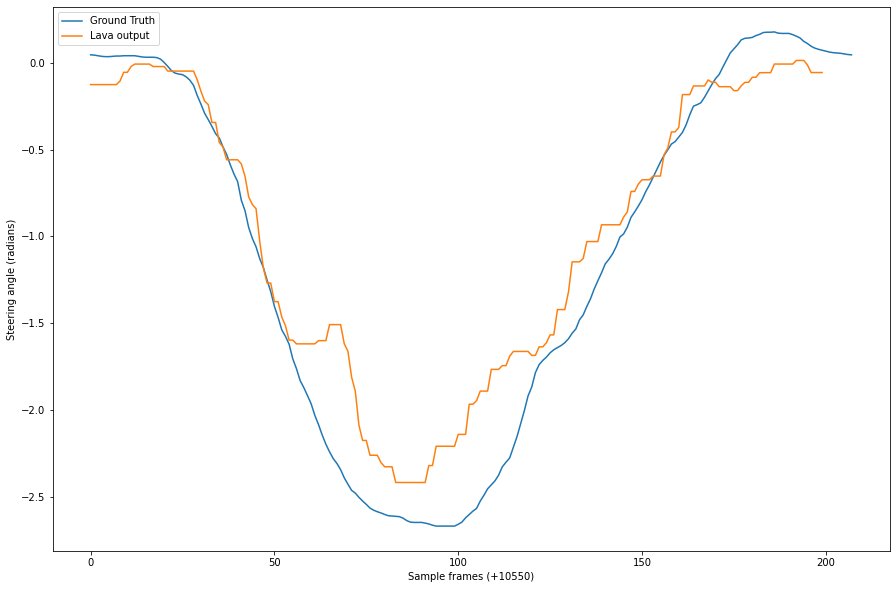

In [10]:
plt.figure(figsize=(15, 10))
plt.plot(np.array(gts[1:]), label='Ground Truth')
plt.plot(np.array(output[len(net.layers):]).flatten()/(1<<18), label='Lava output')
plt.xlabel(f'Sample frames (+10550)')
plt.ylabel('Steering angle (radians)')
plt.legend()